# QGSS Final Project: VQE

### For this optional final challenge, you will be designing your own implementation of a variational quantum eigensolver (VQE) algorithm that simulates the ground state energy of the Lithium Hydride (LiH) molecule.

### Importing necessary libraries

In [1]:
%matplotlib inline
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import warnings
from qiskit.providers.aer import noise

### Function for computing the qubit operations of LiH

In [2]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

### Running VQE on a Statevector simulator

In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    
    #warnings.filterwarnings(action='once') 
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    
print("All energies have been calculated")

/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  ndigits=EVAL_SIG_DIGITS)
/opt/conda/lib/python3.7/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:157: DeprecationWar

Interatomic Distance: 0.5 VQE Result: -7.039673441687295 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.3133088763367216 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500887031066869 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630945412184095 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.72078110092096 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.78221159487579 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.8235680833717005 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850666134298109 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867529585720729 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.87696626123844 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.880979508175356 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881036620267557 Exact Ener

### Plotting the curve

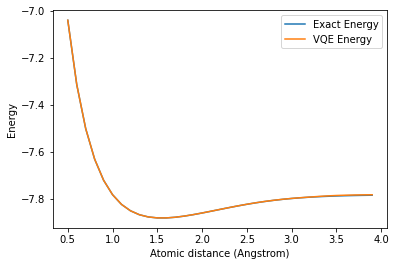

In [4]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

### Running VQE on a Noisy Simulator

In [5]:
provider = IBMQ.load_account()
chip_name = 'ibmq_essex'
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)
distances = np.arange(0.5, 4.0, 0.2)

### I have chosen to compare the different variational forms of the parametrized circuit. For the optimizer, I have fixed COBYLA. 

#### optimizer: COBYLA(Maxiter = 200),  qubit_mapping: parity,  initial_state: HartreeFock,  var_form: UCCSD

In [6]:
exact_energies_uccsd = []
vqe_energies_uccsd = []
optimizer = COBYLA(maxiter=200)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies_uccsd.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)
    vqe_energies_uccsd.append(vqe_result)
    
    warnings.filterwarnings('ignore')
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -6.21489116525218 Exact Energy: [-7.78438961]
Interatomic Distance: 0.7 VQE Result: -6.746734053376193 Exact Energy: [-7.78438961]
Interatomic Distance: 0.9 VQE Result: -6.89449014534648 Exact Energy: [-7.78438961]
Interatomic Distance: 1.1 VQE Result: -6.975076215668603 Exact Energy: [-7.78438961]
Interatomic Distance: 1.3 VQE Result: -7.05498754267728 Exact Energy: [-7.78438961]
Interatomic Distance: 1.5 VQE Result: -7.032288034904687 Exact Energy: [-7.78438961]
Interatomic Distance: 1.7 VQE Result: -7.132846049651834 Exact Energy: [-7.78438961]
Interatomic Distance: 1.9 VQE Result: -7.167619700822045 Exact Energy: [-7.78438961]
Interatomic Distance: 2.1 VQE Result: -7.249217744050411 Exact Energy: [-7.78438961]
Interatomic Distance: 2.3 VQE Result: -7.258171037942708 Exact Energy: [-7.78438961]
Interatomic Distance: 2.5 VQE Result: -7.27136479751008 Exact Energy: [-7.78438961]
Interatomic Distance: 2.7 VQE Result: -7.271331659158278 Exact Energy

#### Plotting the curve

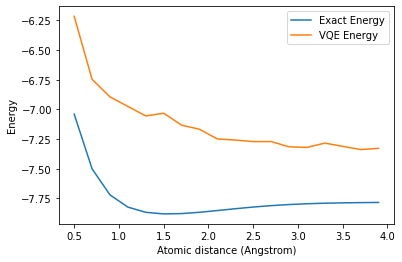

In [7]:
plt.plot(distances, exact_energies_uccsd, label="Exact Energy")
plt.plot(distances, vqe_energies_uccsd, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### optimizer: COBYLA(Maxiter = 200),  qubit_mapping: parity,  initial_state: HartreeFock,  var_form: RY

In [8]:
exact_energies_ry = []
vqe_energies_ry = []
optimizer = COBYLA(maxiter=200)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies_ry.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = RY(
        num_qubits=qubitOp.num_qubits,
        initial_state = initial_state
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)
    vqe_energies_ry.append(vqe_result)
    
    warnings.filterwarnings('ignore')
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -6.461123133420084 Exact Energy: [-7.78438961]
Interatomic Distance: 0.7 VQE Result: -7.01833054983812 Exact Energy: [-7.78438961]
Interatomic Distance: 0.9 VQE Result: -7.226575239202942 Exact Energy: [-7.78438961]
Interatomic Distance: 1.1 VQE Result: -7.1944395934892125 Exact Energy: [-7.78438961]
Interatomic Distance: 1.3 VQE Result: -7.38842994543177 Exact Energy: [-7.78438961]
Interatomic Distance: 1.5 VQE Result: -7.364982604489314 Exact Energy: [-7.78438961]
Interatomic Distance: 1.7 VQE Result: -7.531027790847971 Exact Energy: [-7.78438961]
Interatomic Distance: 1.9 VQE Result: -7.372016557458125 Exact Energy: [-7.78438961]
Interatomic Distance: 2.1 VQE Result: -7.556138932600121 Exact Energy: [-7.78438961]
Interatomic Distance: 2.3 VQE Result: -7.36295996455157 Exact Energy: [-7.78438961]
Interatomic Distance: 2.5 VQE Result: -7.558179513451256 Exact Energy: [-7.78438961]
Interatomic Distance: 2.7 VQE Result: -7.479810553805843 Exact Ener

#### Plotting the curve

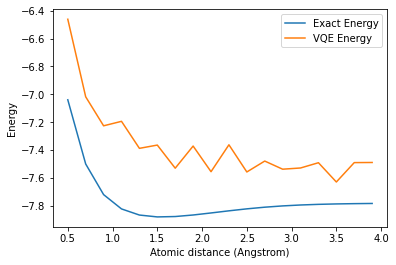

In [9]:
plt.plot(distances, exact_energies_ry, label="Exact Energy")
plt.plot(distances, vqe_energies_ry, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### optimizer: COBYLA(Maxiter = 200),  qubit_mapping: parity,  initial_state: HartreeFock,  var_form: RYRZ

In [10]:
exact_energies_ryrz = []
vqe_energies_ryrz = []
optimizer = COBYLA(maxiter=200)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies_ryrz.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = RYRZ(
        num_qubits=qubitOp.num_qubits,
        initial_state = initial_state
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)
    vqe_energies_ryrz.append(vqe_result)
    
    warnings.filterwarnings('ignore')
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -6.5338573367525905 Exact Energy: [-7.78438961]
Interatomic Distance: 0.7 VQE Result: -6.9902832224368385 Exact Energy: [-7.78438961]
Interatomic Distance: 0.9 VQE Result: -7.2935236819812665 Exact Energy: [-7.78438961]
Interatomic Distance: 1.1 VQE Result: -7.5234551019032825 Exact Energy: [-7.78438961]
Interatomic Distance: 1.3 VQE Result: -7.111769676316599 Exact Energy: [-7.78438961]
Interatomic Distance: 1.5 VQE Result: -7.320430104590139 Exact Energy: [-7.78438961]
Interatomic Distance: 1.7 VQE Result: -7.560084003810272 Exact Energy: [-7.78438961]
Interatomic Distance: 1.9 VQE Result: -7.636774993435403 Exact Energy: [-7.78438961]
Interatomic Distance: 2.1 VQE Result: -7.601365000868182 Exact Energy: [-7.78438961]
Interatomic Distance: 2.3 VQE Result: -7.557939892994124 Exact Energy: [-7.78438961]
Interatomic Distance: 2.5 VQE Result: -7.536176325314887 Exact Energy: [-7.78438961]
Interatomic Distance: 2.7 VQE Result: -7.505217921354838 Exac

#### Plotting the curve

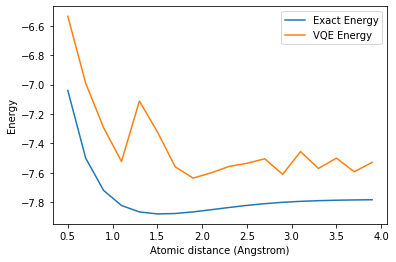

In [11]:
plt.plot(distances, exact_energies_ryrz, label="Exact Energy")
plt.plot(distances, vqe_energies_ryrz, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### optimizer: COBYLA(Maxiter = 200),  qubit_mapping: parity,  initial_state: HartreeFock,  var_form: SwapRZ

In [12]:
exact_energies_swaprz = []
vqe_energies_swaprz = []
optimizer = COBYLA(maxiter=200)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies_swaprz.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = SwapRZ(
        num_qubits=qubitOp.num_qubits,
        initial_state = initial_state
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'] + shift)
    vqe_energies_swaprz.append(vqe_result)
    
    warnings.filterwarnings('ignore')
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -6.221492170088669 Exact Energy: [-7.78438961]
Interatomic Distance: 0.7 VQE Result: -6.804211174088331 Exact Energy: [-7.78438961]
Interatomic Distance: 0.9 VQE Result: -6.920982732806165 Exact Energy: [-7.78438961]
Interatomic Distance: 1.1 VQE Result: -7.037378459409491 Exact Energy: [-7.78438961]
Interatomic Distance: 1.3 VQE Result: -7.2040403856349275 Exact Energy: [-7.78438961]
Interatomic Distance: 1.5 VQE Result: -7.11327401103801 Exact Energy: [-7.78438961]
Interatomic Distance: 1.7 VQE Result: -7.134936909100743 Exact Energy: [-7.78438961]
Interatomic Distance: 1.9 VQE Result: -7.305697465411004 Exact Energy: [-7.78438961]
Interatomic Distance: 2.1 VQE Result: -7.210931297586613 Exact Energy: [-7.78438961]
Interatomic Distance: 2.3 VQE Result: -7.380088842621874 Exact Energy: [-7.78438961]
Interatomic Distance: 2.5 VQE Result: -7.3492014113445245 Exact Energy: [-7.78438961]
Interatomic Distance: 2.7 VQE Result: -7.271114828166015 Exact E

#### Plotting the curve

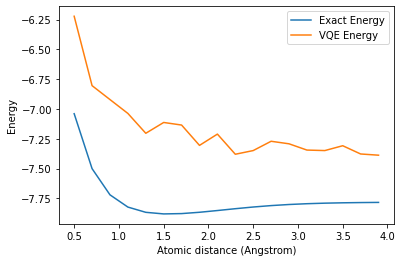

In [13]:
plt.plot(distances, exact_energies_swaprz, label="Exact Energy")
plt.plot(distances, vqe_energies_swaprz, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

#### Now that we have run the VQE with different variational forms, let's compare them:

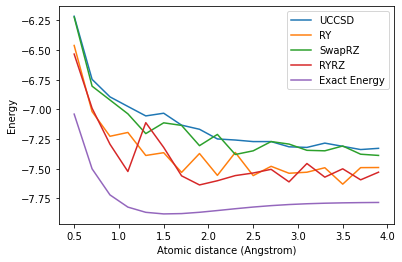

In [14]:
plt.plot(distances, vqe_energies_uccsd, label="UCCSD")
plt.plot(distances, vqe_energies_ry, label="RY")
plt.plot(distances, vqe_energies_swaprz, label="SwapRZ")
plt.plot(distances, vqe_energies_ryrz, label="RYRZ")
plt.plot(distances, exact_energies_swaprz, label="Exact Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()